In [1]:
import numpy as np
from copy import copy
from six import iteritems
from matplotlib import pyplot as plt
from pygenn import genn_model, genn_wrapper

In [2]:
# Load MNIST data (pre-normalized and coverted to numpy format)
training_images = np.load("training_images.npy")
training_labels = np.load("training_labels.npy")

### Visualize training data

(60000, 784)


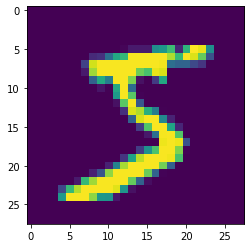

In [3]:
print(training_images.shape)
assert np.allclose(np.sum(training_images, axis=1), 1.0)

fig, axis = plt.subplots()
axis.imshow(np.reshape(training_images[0], (28, 28)))

### Parameters

In [4]:
DT = 0.1
INPUT_SCALE = 80.0
NUM_PN = 784
NUM_KC = 20000
PRESENT_TIME_MS = 20.0

# Standard LIF neurons parameters
LIF_PARAMS = {
    "C": 0.2,
    "TauM": 20.0,
    "Vrest": -60.0,
    "Vreset": -60.0,
    "Vthresh": -50.0,
    "Ioffset": 0.0,
    "TauRefrac": 2.0}

# We only want PNs to spike once
PN_PARAMS = copy(LIF_PARAMS)
PN_PARAMS["TauRefrac"] = 20.0

PN_KC_WEIGHT = 0.15
PN_KC_TAU_SYN = 3.0
PN_KC_FAN_IN = 20

### Custom models

In [5]:
# Current source model, allowing current to be injected into neuron from variable
cs_model = genn_model.create_custom_current_source_class(
    "cs_model",
    var_name_types=[("magnitude", "scalar")],
    injection_code="$(injectCurrent, $(magnitude));")

### Model definition

In [6]:
# Create model
model = genn_model.GeNNModel("float", "mnist_mb")
model.dT = DT
model._model.set_seed(1337)

# Create neuron populations
lif_init = {"V": PN_PARAMS["Vreset"], "RefracTime": 0.0}
pn = model.add_neuron_population("pn", NUM_PN, "LIF", PN_PARAMS, lif_init)
kc = model.add_neuron_population("kc", NUM_KC, "LIF", LIF_PARAMS, lif_init)

# Turn on spike recording
pn.spike_recording_enabled = True
kc.spike_recording_enabled = True

# Create current sources to deliver input to network
pn_input = model.add_current_source("pn_input", cs_model, pn , {}, {"magnitude": 0.0})

# Create synapse populations
pn_kc = model.add_synapse_population("pn_kc", "SPARSE_GLOBALG", genn_wrapper.NO_DELAY,
                                     pn, kc,
                                     "StaticPulse", {}, {"g": PN_KC_WEIGHT}, {}, {},
                                     "ExpCurr", {"tau": PN_KC_TAU_SYN}, {},
                                     genn_model.init_connectivity("FixedNumberPreWithReplacement", {"colLength": PN_KC_FAN_IN}))

### Build model

In [7]:
# Convert present time into timesteps
present_timesteps = int(round(PRESENT_TIME_MS / DT))

# Build model and load it
model.build()
model.load(num_recording_timesteps=present_timesteps)

### Simulation

655 KC active
655 KC active
655 KC active
655 KC active


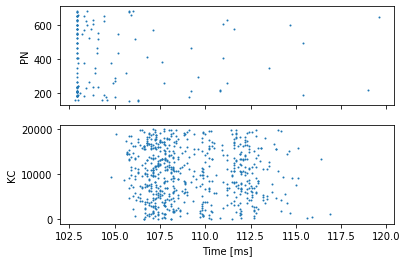

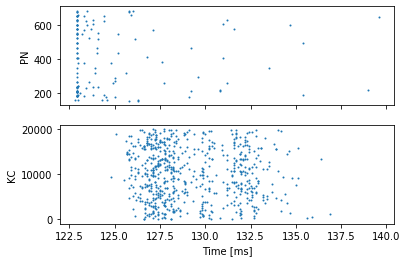

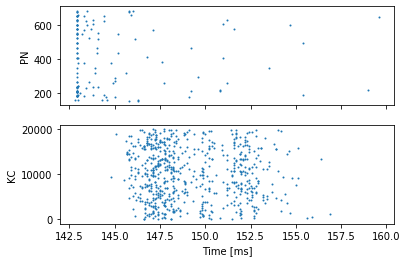

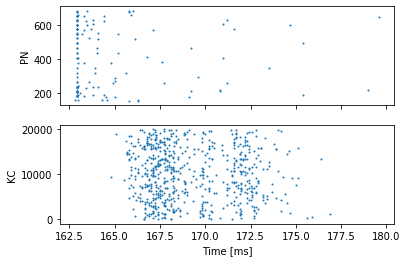

In [11]:
def reset_neuron(pop, var_init):
    # Reset variables
    for var_name, var_val in iteritems(var_init):
        pop.vars[var_name].view[:] = var_val
    
    # Push the state to GPU
    pop.push_state_to_device()

def reset_in_syn(pop):
    pop.in_syn[:] = 0.0
    pop.push_in_syn_to_device()

for s in range(4):
    # Set training image
    pn_input.vars["magnitude"].view[:] = training_images[s] * INPUT_SCALE
    pn_input.push_var_to_device("magnitude")

    # Simulate present timesteps
    for i in range(present_timesteps):
        model.step_time()
    
    # Reset neuron state for next stimuli
    reset_neuron(pn, lif_init)
    reset_neuron(kc, lif_init)
    
    # Reset synapse state
    reset_in_syn(pn_kc)
    
    # Download spikes from GPU
    model.pull_recording_buffers_from_device();
    
    # Plot PN and KC spikes
    fig, axes = plt.subplots(2, sharex=True)
    pn_spike_times, pn_spike_ids = pn.spike_recording_data
    kc_spike_times, kc_spike_ids = kc.spike_recording_data
    print("%u KC active" % len(np.unique(kc_spike_ids)))
    axes[0].scatter(pn_spike_times, pn_spike_ids, s=1)
    axes[0].set_ylabel("PN")
    axes[1].scatter(kc_spike_times, kc_spike_ids, s=1)
    axes[1].set_xlabel("Time [ms]")
    axes[1].set_ylabel("KC")
plt.show()